<h1>Выбор локации для скважины<a class="tocSkip"></h1>
   
<h2>Краткое описание<a class="tocSkip"></h2>

Для добывающей компании «ГлавРосГосНефть» необходимо решить, где бурить новую скважину.

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. 
    
<h2>Цель проекта<a class="tocSkip"></h2>
    
Построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль.
Проанализировать возможную прибыль и риски техникой *Bootstrap.*
    
Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.
    
<h2>Описание данных<a class="tocSkip"></h2> 
  
Три датасета с данными геологоразведки трёх регионов:
    
- `geo_data_0.csv` 
- `geo_data_1.csv` 
- `geo_data_2.csv` 
    
Данные:   
    
- `id` — уникальный идентификатор скважины;
- `f0, f1, f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
- `product` — объём запасов в скважине (тыс. баррелей). 


In [1]:
!pip install matplotlib==3.5.1 -q

In [2]:
!pip install --upgrade -q scikit-learn

In [3]:
#импортируем используемые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots

import sklearn

# для разделения выборки
from sklearn.model_selection import train_test_split

# метрики
from sklearn.metrics import mean_squared_error

# импорт модели
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

In [4]:
#Константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

<h2><b>Оглавление</b><a class="tocSkip"></h2>

<a href='#Step0'><b>Функции, используемые в проекте</b></a>   
    
<a href='#Step1'><b>1. Загрузка и подготовка данных</b></a>
    
<a href='#Step2'><b>2. Обучение и проверка модели</b></a>
- <a href='#Step2.1'><b>2.1 Модель машинного обучения для первого региона</b></a>
- <a href='#Step2.2'><b>2.2 Модель машинного обучения для второго региона</b></a>
- <a href='#Step2.3'><b>2.3 Модель машинного обучения для третьего региона</b></a>
- <a href='#Step2.4'><b>2.4 Вывод по разделу</b></a>
    
<a href='#Step3'><b>3. Подготовьтесь к расчёту прибыли</b></a>
- <a href='#Step3.1'><b>3.1 Расчеты</b></a>
- <a href='#Step3.2'><b>3.2 Вывод по разделу</b></a>
    
<a href='#Step4'><b>4. Расчет прибыли и рисков</b></a>
- <a href='#Step4.1'><b>4.1 Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели</b></a>    
- <a href='#Step4.2'><b>4.2 Риски и прибыль для каждого региона</b></a>
- <a href='#Step4.3'><b>4.3 Вывод по разделу</b></a> 
   
<a href='#StepFinal'><b>Итоговый вывод</b></a> 

<a id='Step0'></a>
<h3><b> Функции, используемые в проекте<a class="tocSkip"></h3>

In [5]:
#Функция для отображения основной информации по датафрейму

def check_df (dataframes):
    for df in dataframes:
        df_name = [name for name, obj in globals().items() if obj is df][0]
        print(f'Общая информация по датафрейму {df_name}:')
        # общая информация
        df.info()
        # описательная статистика
        display(df.describe())
        # первые 5 строк
        display(df.head())
        print()

In [6]:
#Функция проверки на пропущенные значения и явные дубликаты

def check_isna_dupl (dataframes):
    for df in dataframes:
        df_name = [name for name, obj in globals().items() if obj is df][0]
        print(f'В датафрейме {df_name}:')
        print(f'Количество пропущенных значений:\n{df.isna().sum()} \
        \nКоличество явных дубликатов: {df.duplicated().sum()}')
        print()

In [7]:
#Функция построения графика гистограмм распределения

def hist_plot (dataframes):  
    for df in dataframes:
        # Создание графика с 4 подграфиками в два столбца
        fig, axes = plt.subplots(2, 2, figsize=(12, 15))
        # Преобразование 2D массива подграфиков в 1D для удобного индексирования
        axes = axes.ravel()
        df_name = [name for name, obj in globals().items() if obj is df][0]
        for i, column in enumerate(df.columns):
            sns.histplot(data=df, bins=20, 
                         x=column, legend=True, ax=axes[i], 
                         color='skyblue')
            axes[i].set_title(f'Распределение {column} в {df_name}')
    
            # Добавление медианы и среднего значения
            median_value = df[column].median()
            mean_value = df[column].mean()
            axes[i].axvline(median_value, color='r', linestyle='--', label=f'Median: {median_value:.2f}')
            axes[i].axvline(mean_value, color='g', linestyle='-', label=f'Mean: {mean_value:.2f}')
            axes[i].legend()
            axes[0].legend(loc='upper right')

            # Показать графики
        plt.tight_layout()
        plt.show();

In [8]:
#Функция построения графика гистограмм распределения

def hist_plot (dataframes):  
    for df in dataframes:
        # Создание графика с 4 подграфиками в два столбца
        fig, axes = plt.subplots(2, 2, figsize=(12, 15))
        # Преобразование 2D массива подграфиков в 1D для удобного индексирования
        axes = axes.ravel()
        df_name = [name for name, obj in globals().items() if obj is df][0]
        for i, column in enumerate(df.columns):
            sns.histplot(data=df, bins=20, 
                         x=column, legend=True, ax=axes[i], 
                         color='skyblue')
            axes[i].set_title(f'Распределение {column} в {df_name}')
    
            # Добавление медианы и среднего значения
            median_value = df[column].median()
            mean_value = df[column].mean()
            axes[i].axvline(median_value, color='r', linestyle='--', label=f'Median: {median_value:.2f}')
            axes[i].axvline(mean_value, color='g', linestyle='-', label=f'Mean: {mean_value:.2f}')
            axes[i].legend()
            axes[0].legend(loc='upper right')

            # Показать графики
        plt.tight_layout()
        plt.show();

<a id='Step1'></a>
## Загрузка и подготовка данных

In [9]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [10]:
check_df([geo_data_0, geo_data_1, geo_data_2])

Общая информация по датафрейму geo_data_0:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647



Общая информация по датафрейму geo_data_1:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305



Общая информация по датафрейму geo_data_2:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [11]:
check_isna_dupl([geo_data_0, geo_data_1, geo_data_2])

В датафрейме geo_data_0:
Количество пропущенных значений:
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64         
Количество явных дубликатов: 0

В датафрейме geo_data_1:
Количество пропущенных значений:
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64         
Количество явных дубликатов: 0

В датафрейме geo_data_2:
Количество пропущенных значений:
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64         
Количество явных дубликатов: 0



Рассмотрим распределение признаков в трех датафреймах.

In [12]:
geo_data_0 = geo_data_0.drop(columns=['id'])
geo_data_1 = geo_data_1.drop(columns=['id'])
geo_data_2 = geo_data_2.drop(columns=['id'])

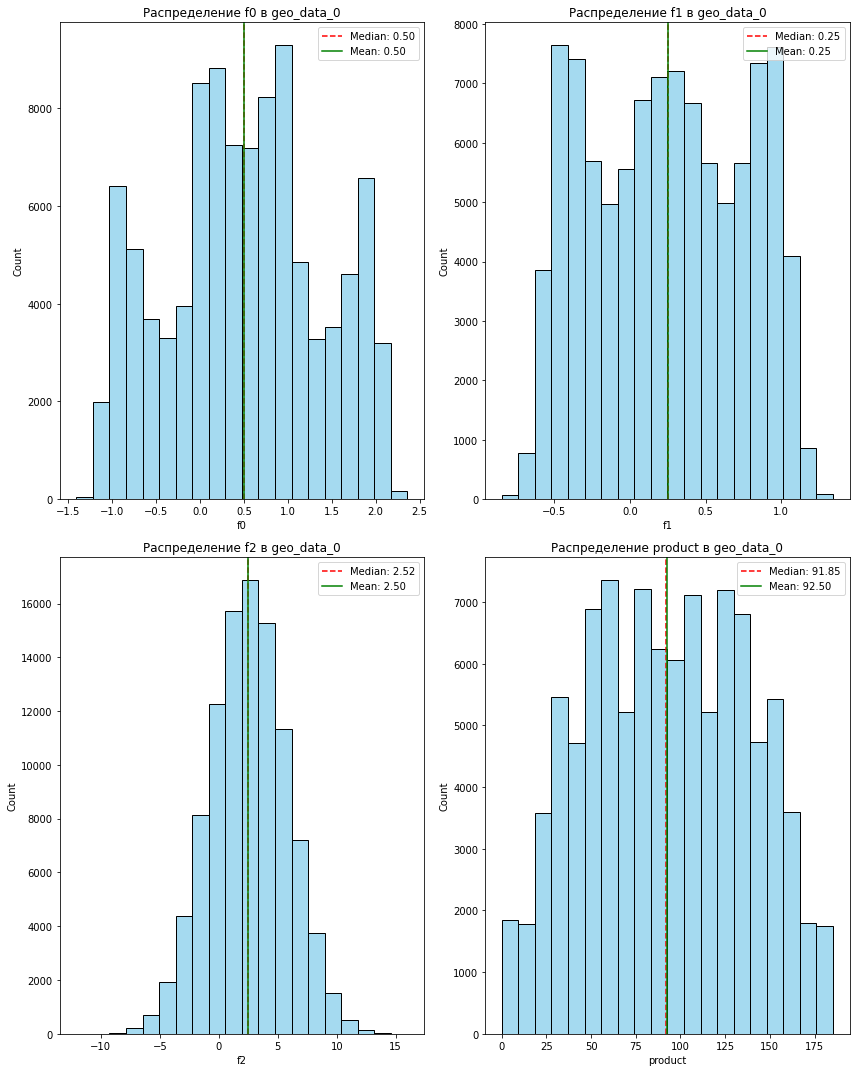

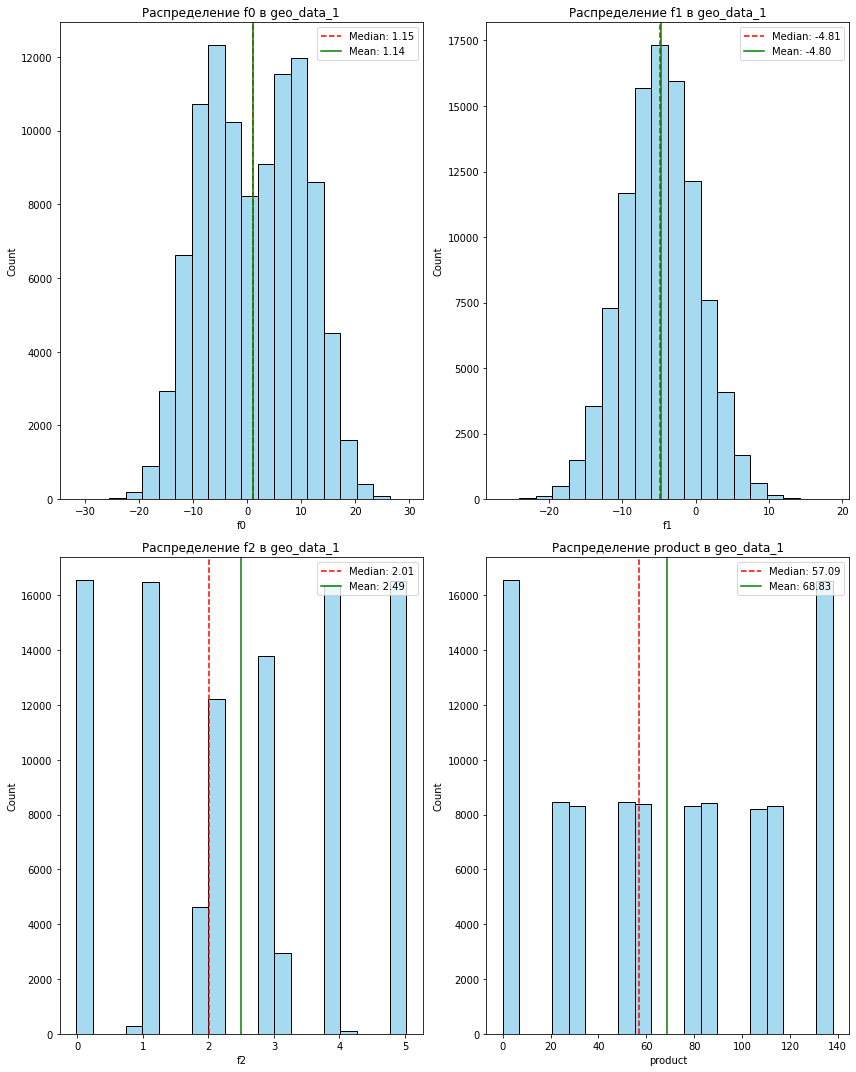

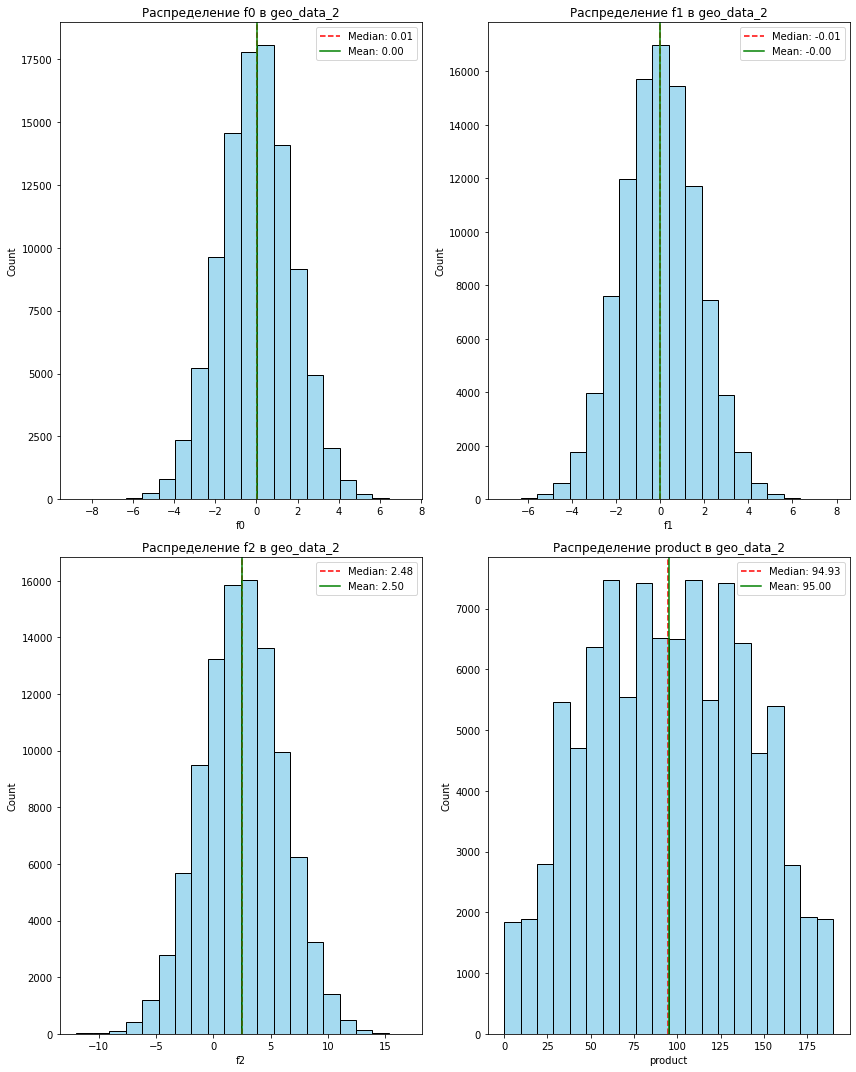

In [13]:
hist_plot([geo_data_0, geo_data_1, geo_data_2])

**Итоги по этапу 1**

- Выгрузили 3 датафрейма в переменные `geo_data_0, geo_data_1, geo_data_2`
- Вывели информацию по датафреймам:
    1. Пропущенных значений нет
    2. Явных дубликатов нет
    3. Данные имеют правильные типы
    
- Посмотрели на распределение целевого признака. В двух регионах целевой признак (запасы нефти) имеет нормальное распределение.
- **Убрали колонки `id` из всех датафреймов, так как для модели это незначимый признак.**
- Данные готовы к работе, переидем к следующему этапу

1. В первом регионе стремятся к нормальному распределению, но существуют пики слева и справа от медианы.
2. Во втором регионе отсутствует нормальное распределение входных признаков.
3. В третьем регионе входные признаки распределены нормально.
        
Дополнительно посмотрим корреляцию входных признаков с целевым

In [14]:
def corr_hitmap(dataframes):
    for df in dataframes:
        df_name = [name for name, obj in globals().items() if obj is df][0]
        corr_matrix = df.corr()
        plt.figure(figsize = (15, 10))
        sns.heatmap(corr_matrix, vmin=-1, vmax=1,
            cmap='GnBu', annot=True,
            linewidths=1, linecolor='black')
        plt.title(f'Матрица корреляции для {df_name}')
        plt.xticks(rotation=45) 
        plt.show()

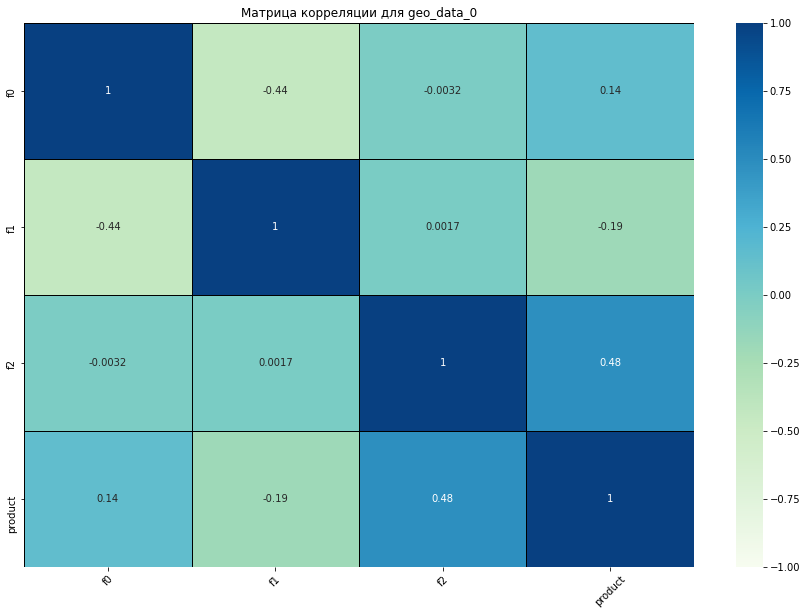

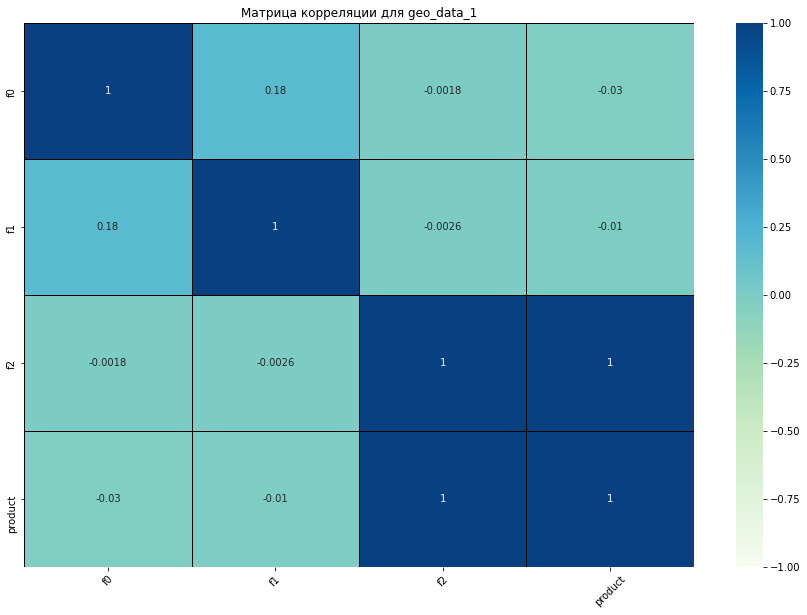

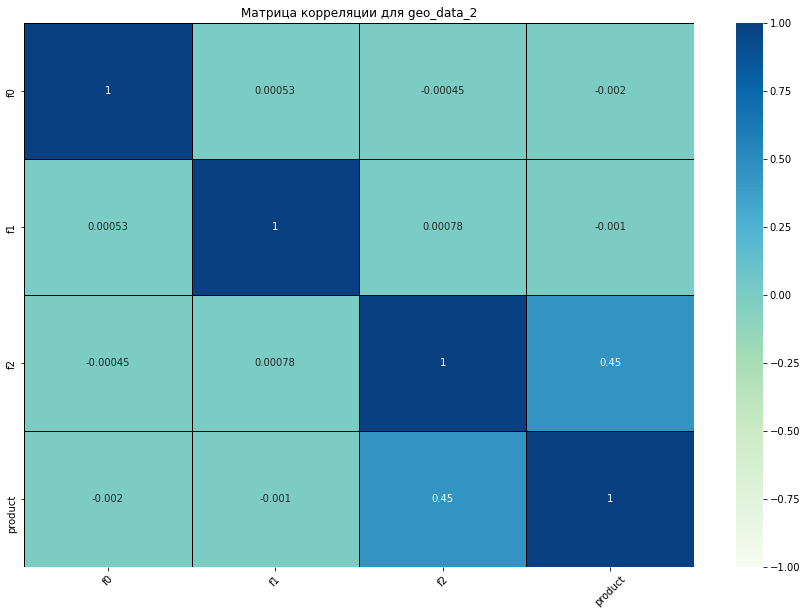

In [15]:
corr_hitmap([geo_data_0, geo_data_1, geo_data_2])

1. Во втором регионе очень высокая сила связи по шкале Чеддока у входного признака `f2` с целевым `product`
2. В первом и третьем регионе имеют слабую корреляцию входной признак `f2` с целевым.
3. Остальные входные признаки имеют очень слабую связь - `0`

<a id='Step2'></a>
## Обучение и проверка модели

Сделаем функцию, в которой:
1. Разбьем данные на обучающую и валидационную выборки в соотношении 75:25
2. Обучим модель и сделаем предсказания на валидационной выборке.
3. Сохраним предсказания и правильные ответы на валидационной выборке.
4. Напечатаем на экране средний запас предсказанного сырья и RMSE модели.

Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).

In [16]:
model = LinearRegression()

def oil_predict(df, target_name):
    X = df.drop([target_name] , axis=1)
    y = df[target_name]
    
    X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_valid)
    data = {'real_product' : y_valid,
            'predicted_product' : y_predicted         
    }
    data_frame = pd.DataFrame(data, columns = ['real_product', 'predicted_product'])
    rmse = mean_squared_error(y_valid, y_predicted)**0.5
    mean = data_frame['predicted_product'].mean()
    oil_sum = data_frame['predicted_product'].sum()
    mean_real = data_frame['real_product'].mean()
    return data_frame, rmse, mean, oil_sum, mean_real

<a id='Step2.1'></a>
### Модель машинного обучения для первого региона

In [17]:
data_frame_0, rmse_0, mean_0, oil_sum_0, mean_real_0 = oil_predict(geo_data_0, 'product')

print('Настоящие и предсказанные данные по местороджению geo_data_0' '\n',
    data_frame_0.head(), '\n'
    '\n'
    'RMSE -', rmse_0, '\n'
    'Средний запас сырья предсказанный -', mean_0, '\n'
    'Средний запас сырья реальный -', mean_real_0, '\n'
    'Суммарный запас сырья в регионе - ', oil_sum_0, '\n'
     )

Настоящие и предсказанные данные по местороджению geo_data_0
        real_product  predicted_product
75721    122.073350         101.901017
80184     48.738540          78.217774
19864    131.338088         115.266901
76699     88.327757         105.618618
92991     36.959266          97.980185 

RMSE - 37.75660035026169 
Средний запас сырья предсказанный - 92.39879990657768 
Средний запас сырья реальный - 92.32595637084387 
Суммарный запас сырья в регионе -  2309969.997664442 



<a id='Step2.2'></a>
### Модель машинного обучения для второго региона

In [18]:
data_frame_1, rmse_1, mean_1, oil_sum_1, mean_real_1 = oil_predict(geo_data_1, 'product')

print('Настоящие и предсказанные данные по местороджению geo_data_1' '\n',
    data_frame_1.head(), '\n'
    '\n'
    'RMSE -', rmse_1, '\n'
    'Средний запас сырья предсказанный -', mean_1, '\n'
    'Средний запас сырья реальный -', mean_real_1, '\n'
    'Суммарный запас сырья в регионе - ', oil_sum_1
     )

Настоящие и предсказанные данные по местороджению geo_data_1
        real_product  predicted_product
75721      0.000000           0.844738
80184     53.906522          52.921612
19864    134.766305         135.110385
76699    107.813044         109.494863
92991      0.000000          -0.047292 

RMSE - 0.890280100102884 
Средний запас сырья предсказанный - 68.71287803913762 
Средний запас сырья реальный - 68.72538074722745 
Суммарный запас сырья в регионе -  1717821.9509784407


<a id='Step2.3'></a>
### Модель машинного обучения для третьего региона

In [19]:
data_frame_2, rmse_2, mean_2, oil_sum_2, mean_real_2 = oil_predict(geo_data_2, 'product')

print('Настоящие и предсказанные данные по местороджению geo_data_2' '\n',
    data_frame_2.head(), '\n'
    '\n'
    'RMSE -', rmse_2, '\n'
    'Средний запас сырья предсказанный -', mean_2, '\n'
    'Средний запас сырья реальный -', mean_real_2, '\n'
    'Суммарный запас сырья в регионе - ', oil_sum_2
     )

Настоящие и предсказанные данные по местороджению geo_data_2
        real_product  predicted_product
75721    117.441301          98.301916
80184     47.841249         101.592461
19864     45.883483          52.449099
76699    139.014608         109.922127
92991     84.004276          72.411847 

RMSE - 40.145872311342174 
Средний запас сырья предсказанный - 94.77102387765939 
Средний запас сырья реальный - 95.15099907171961 
Суммарный запас сырья в регионе -  2369275.5969414846


<a id='Step2.4'></a>
### Вывод по разделу

- Применили модель линейной регрессии `LinearRegression()` для решения задачи
- Для каждого региона посчитали предсказания и создали датафрейм с реальными и предсказанными значениями
- Посчитали RMSE для каждого региона.

1. Модель хорошо предсказала значения для второго региона. `RMSE` равен `0.89`. Хуже для первого и второго - `RMSE` равен `37.75` и `40.14` соответственно.
2. Больше всего среднего запаса сырья в третьем регионе `94.77` тыс. баррелей, затем во втором и третьем.

## Подготовка к расчёту прибыли

<a id='Step3.1'></a>
### Расчеты

Все ключевые значения для расчётов сохраним в отдельных переменных.

In [20]:
FULL_BUDGET = 1e+10 
FULL_POINTS = 500
BEST_POINTS = 200
PRICE_PER_BARREL = 450000

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. 

In [21]:
#Посчитаем сколько бюджет в среднем на каждую скважину (200 лучших)
profit_per_point_avg = FULL_BUDGET / (BEST_POINTS * 1000)
#Расчет среднего количества баррелей сырья на каждую скважину исходя из бюджета 10 млрд
barrels_per_point_avg = profit_per_point_avg  / (PRICE_PER_BARREL*0.001)
#Средний необходимый объем сырья на целый регион
amount_barrels_avg = FULL_BUDGET / PRICE_PER_BARREL

print('Средний бюджет на лучшую точку -', profit_per_point_avg, 'тыс. руб.')
print('Средний объем сырья на точку -',barrels_per_point_avg, 'тыс. барелей')
print('Средний объем сырья на регион -',amount_barrels_avg, 'тыс. барелей')

Средний бюджет на лучшую точку - 50000.0 тыс. руб.
Средний объем сырья на точку - 111.11111111111111 тыс. барелей
Средний объем сырья на регион - 22222.222222222223 тыс. барелей


Сравним полученный объём сырья со средним запасом в каждом регионе. 

In [22]:
print(
     'Средний запас предсказанного сырья на точку в регионе 1', mean_0, '\n'
     'Средний запас предсказанного сырья на точку в регионе 2', mean_1, '\n'
     'Средний запас предсказанного сырья на точку в регионе 3', mean_2
     )
print()

print(
     'Средний запас реального сырья на точку в регионе 1', mean_real_0, '\n'
     'Средний запас реального сырья на точку в регионе 2', mean_real_1, '\n'
     'Средний запас реального сырья на точку в регионе 3', mean_real_2
     )
print()

print('Рассчитанный объем сырья на точку (значение безубытка) -', round(barrels_per_point_avg,2), 'тыс. барелей')



#print(
#     'Суммарный запас предсказанного сырья в регионе 1', oil_sum_0, '\n'
#     'Суммарный запас предсказанного сырья в регионе 2', oil_sum_1, '\n'
#     'Суммарный запас предсказанного сырья в регионе 3', oil_sum_2
#     )

Средний запас предсказанного сырья на точку в регионе 1 92.39879990657768 
Средний запас предсказанного сырья на точку в регионе 2 68.71287803913762 
Средний запас предсказанного сырья на точку в регионе 3 94.77102387765939

Средний запас реального сырья на точку в регионе 1 92.32595637084387 
Средний запас реального сырья на точку в регионе 2 68.72538074722745 
Средний запас реального сырья на точку в регионе 3 95.15099907171961

Рассчитанный объем сырья на точку (значение безубытка) - 111.11 тыс. барелей


<a id='Step3.2'></a>
### Вывод по разделу

- Произвели подготовку к расчету
- Ключевые значения указали в переменных `full_budget, full_points, best_points, price_per_barrel`
- Средний бюджет на лучшую точку - `50000.0 тыс. руб.` 
- Средний объем сырья на точку - `111 тыс. барелей`
- Средний объем сырья на регион - `22222 тыс. барелей`

1. Второй регион имеет меньшие запасы сырья, чем рассчитанный средний запас сырья в регион исходя из бюджета 10 млрд руб.
2. Для первого и третьего регионов - высокая вероятность окупить затраты.
3. Средние запасы сырья на скважину в первом и третьем регионах также близки к рассчитанному среднему.

## Расчёт прибыли и рисков 

<a id='Step4.1'></a>
### Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
1. Выберем скважины с максимальными значениями предсказаний. 
2. Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям.
3. Рассчитаем прибыль для полученного объёма сырья.

In [23]:
def profit_from_points(target, preds, count):
    sum_oil =  target[preds.sort_values(ascending=False).index][:count].sum()
    return sum_oil * (PRICE_PER_BARREL/1000) - FULL_BUDGET/1000

<a id='Step4.2'></a>
### Риски и прибыль для каждого региона

Посчитаем риски и прибыль для каждого региона:
1. Применим технику Bootstrap с `1000` выборок, чтобы найти распределение прибыли.
2. Найдем среднюю прибыль, `95%-й` доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.

In [28]:
#Напишем функцию распределения прибыли, чтобы применить ее к датафреймам по трём регионам

state_bootstrap = np.random.RandomState(341546)
def profit_distribution(target, predicts):
    values=[]
#    loss = 0
    for i in range(1000):
        predicts_sample = predicts[target.sample(replace=True, random_state=state_bootstrap, n=FULL_POINTS).index]
        profit = profit_from_points(target, predicts_sample, BEST_POINTS)
#        if profit < 0:
#            loss +=1
        values.append(profit)
    
    # считаем доверительный интервал
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    average = values.mean()
    risk = (values < 0).mean()
    #считаем риск убытков
#    risk = loss / 1000
    
    print(f'95% доверительный интервал доходности находится в пределах от {lower} до {upper} тыс. руб')
    print('Средний доход, тыс.руб     :', average)
    print(f'Вероятность убытка: {risk:.2%} ')

In [29]:
print('Распределение прибыли для первого региона')
profit_distribution(data_frame_0['real_product'], data_frame_0['predicted_product'])

Распределение прибыли для первого региона
95% доверительный интервал доходности находится в пределах от -145066.80564226868 до 906601.7408508782 тыс. руб
Средний доход, тыс.руб     : 400033.0590469803
Вероятность убытка: 7.30% 


In [30]:
print('Распределение прибыли для второго региона')
profit_distribution(data_frame_1['real_product'], data_frame_1['predicted_product'])

Распределение прибыли для второго региона
95% доверительный интервал доходности находится в пределах от 44632.395396231164 до 861521.4641012792 тыс. руб
Средний доход, тыс.руб     : 439749.24710010266
Вероятность убытка: 1.70% 


In [31]:
print('Распределение прибыли для третьего региона')
profit_distribution(data_frame_2['real_product'], data_frame_2['predicted_product'])

Распределение прибыли для третьего региона
95% доверительный интервал доходности находится в пределах от -149104.78724573477 до 955866.0710337913 тыс. руб
Средний доход, тыс.руб     : 392595.1655586924
Вероятность убытка: 8.00% 


<a id='Step4.3'></a>
### Вывод по разделу

- Написали функцию для распределения прибыли, а также функцию с техникой Bootstrap для расчета среднего дохода, доверительного интервала и вероятности убытка для каждого региона
- Расчет показал `Регион 2` как самый выгодный вариант по разработке месторождения:
    1. `95% доверительный интервал` доходности находится в пределах от `44632 до 861521 тыс. руб`
    2. Средний доход     : `439749 тыс. руб`
    3. Вероятность убытка: `1.70%`
- Регионы 1 и 3 имеют риск убытка выше `7.3%` и `8%` соответственно
- Доверительный интервал для второго региона показывает, что даже при нижней границе доходность положительная.

<a id='StepFinal'></a>
# Итоговый вывод

В проекте для добывающей компании «ГлавРосГосНефть» решили, где бурить новую скважину:

- Построили модель машинного обучения, которая помогла определить регион, где добыча принесёт наибольшую прибыль. 
- Проанализировали возможную прибыль и риски техникой Bootstrap.


**Для инвестирования предлагается выбрать второй регион. В этом регионе ожидаемая доходность `439749 тыс. руб`, а верояность убытка `1.7%`. Среди регионов с вероятностью убытка, находящегося в пределах допустимого значения 2.5%, в данном регионе самая высокая ожидаемая прибыль.**